In [105]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from BaselineMean import BaselineMean
from BaselineRandom import BaselineRandom
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
PATH_CSV = './top_3827348_songs.csv'
SAMPLE_SIZE = None
SEED = 42
TRAIN_TEST_SPLIT = 0.75

In [6]:
def to_str(x):
    return x[2:-1]

def to_list(x):
    return [y for y in to_str(x).split(',')]

df_complete = pd.read_csv(
    PATH_CSV,
    converters={
        'id': to_str, 'name': to_str, 'duration': np.int32, 'explicit': np.int32,
        'popularity': np.int32, 'loudness': np.float32, 'tempo': np.float32,
        'time_signature': np.int32, 'key': np.int32, 'mode': np.int32, 'acousticness': np.float32,
        'danceability': np.float32, 'energy': np.float32, 'instrumentalness': np.float32,
        'liveness': np.float32, 'speechiness': np.float32, 'valence': np.float32,
        'artist_ids': to_list, 'artist_names': to_list, 'artist_followers': to_list,
        'artist_popularities': to_list, 'album_ids': to_list, 'album_names': to_list,
        'album_types': to_list, 'album_release_dates': to_list, 'album_popularities': to_list,
        'genres': to_list
    }
)
df_complete.head()

,id,name,duration,explicit,popularity,loudness,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,artist_ids,artist_names,artist_followers,artist_popularities,album_ids,album_names,album_types,album_release_dates,album_popularities,genres
0,0000gBWfr2zIFzE5tDzxca,Sella Stercoraria,507987,0,3,-8.065,80.509003,4,9,0,0.000013,0.322,0.670,0.559000,0.3510,0.0449,0.176,[0Tgtl5beIMahbtIzV5jBXw],[Rattenf\xc3\xa4nger],[950],[7],[1HyOZ6YUbaWNdnPjo9UOUE],[Geisslerlieder],[album],[1575590400000],[8],[ukrainian metal]
1,0003Z98F6hUq7XxqSRM87H,\xd0\x9c\xd0\xb5\xd0\xbd\xd1\x8f \xd0\xb1\xd0\xbe\xd0\xbb\xd1\x8c\xd1\x88\xd0\xb5 \xd1\x82\xd1\x83\xd1\x82 \xd0\xbd\xd0\xb5\xd1\x82,241666,1,18,-5.408,138.076004,4,1,1,0.086000,0.733,0.711,0.000000,0.4510,0.1580,0.346,[08RxfNkJpjJ4dJb4xASWzj],[Jacques Anthony],[0],[0],[0003Z98F6hUq7XxqSRM87H],[#NoName],[album],[1436400000000],[17],"[russian hip hop, russian trap]"
2,0003q2V7hAiIYyzXV4sNyQ,"Das wilde Pack, Teil 1: Das wilde Pack, Kapitel 5",200974,0,11,-14.880,79.250000,3,0,1,0.500000,0.520,0.416,0.000000,0.5950,0.9540,0.538,[7vYT04Nb7z9QUTf4F8oG2c],[Das wilde Pack],[3090],[24],[7uwWybYhEK3rhg6QDJo9Rw],[Teil 1: Das wilde Pack],[album],[1225238400000],[21],[kleine hoerspiel]
3,000490QTLqT1ftnfwj3kGF,Disco Guitar,73195,0,2,-14.496,157.445007,4,1,1,0.665000,0.742,0.661,0.000052,0.3070,0.1180,0.922,[0cKrM2XKF7wxyfEQDauvyQ],[DJ Godfather],[0],[0],[1sDqcoOS1JuKSFHNkcU4jL],[Da Bomb Vol 1],[album],[975974400000],[10],"[electro, ghettotech]"
4,00053lDuLvN8Q8voGT3GCt,Soki,279880,0,1,-5.135,104.961998,4,7,1,0.673000,0.622,0.734,0.000002,0.0954,0.0476,0.481,[6HAIuUS4d8W4zjDTl6rsaU],[Barbara Kanam],[0],[0],[6XAXAPWJCpXmracdcF30Jr],[Karibu],[album],[1230768000000],[14],[makossa]


In [124]:
if SAMPLE_SIZE is not None:
    df = df_complete.sample(n=SAMPLE_SIZE, random_state=SEED).copy()
else:
    df = df_complete.copy()

In [125]:
df = df.set_index('id')
df = df[df['artist_names'].apply(lambda x: 'Taylor Swift' in x)]
df = df.sort_values(by='popularity', ascending=False)
print(len(df))
df.head()

478


,name,duration,explicit,popularity,loudness,tempo,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,artist_ids,artist_names,artist_followers,artist_popularities,album_ids,album_names,album_types,album_release_dates,album_popularities,genres
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0lx2cLdOt3piJbcaXIV74f,willow,214706,0,86,-9.195,81.112000,4,7,1,0.83300,0.392,0.574,0.001790,0.1450,0.1700,0.529,[06HL4z0CvFAxyc27GXpf02],[Taylor Swift],[38455481],[97],[2Xoteh7uEpea4TohMxjtaq],[evermore],[album],[1607644800000],[89],"[pop, post-teen pop]"
4R2kfaDFhslZEMJqAFNpdd,cardigan,239560,0,84,-8.588,130.033005,4,0,0,0.53700,0.613,0.581,0.000345,0.2500,0.0424,0.551,[06HL4z0CvFAxyc27GXpf02],[Taylor Swift],[38455481],[97],[2fenSS68JI1h4Fo296JfGr],[folklore],[album],[1595548800000],[89],"[pop, post-teen pop]"
0sY6ZUTh4yoctD8VIXz339,champagne problems,244000,1,82,-12.077,171.319000,4,0,1,0.92000,0.462,0.240,0.000000,0.1130,0.0377,0.320,[06HL4z0CvFAxyc27GXpf02],[Taylor Swift],[38455481],[97],[2Xoteh7uEpea4TohMxjtaq],[evermore],[album],[1607644800000],[89],"[pop, post-teen pop]"
4pvb0WLRcMtbPGmtejJJ6y,exile (feat. Bon Iver),285634,0,82,-8.426,75.601997,4,6,1,0.77800,0.298,0.380,0.000056,0.1100,0.0287,0.152,"[06HL4z0CvFAxyc27GXpf02, 4LEiUm1SRbFMgfqnQTwUbQ]","[Taylor Swift, Bon Iver]","[38455481, 2951666]","[97, 80]",[2fenSS68JI1h4Fo296JfGr],[folklore],[album],[1595548800000],[89],"[pop, post-teen pop, eau claire indie, indie folk, melancholia]"
6RRNNciQGZEXnqk8SQ9yv5,You Need To Calm Down,171360,0,81,-5.617,85.026001,4,2,1,0.00929,0.771,0.671,0.000000,0.0637,0.0553,0.714,[06HL4z0CvFAxyc27GXpf02],[Taylor Swift],[38455481],[97],[1NAmidJlEaVgA3MpcPFYGq],[Lover],[album],[1566518400000],[89],"[pop, post-teen pop]"


In [162]:
df_data = df.select_dtypes(include='number').drop(columns=['popularity']).copy()
df_labels = df[['popularity']].copy()
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, train_size=TRAIN_TEST_SPLIT, random_state=SEED)

In [163]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [164]:
mm_scaler = MinMaxScaler()
y_train = mm_scaler.fit_transform(y_train)
y_test = mm_scaler.transform(y_test)

In [165]:
hgbm = HistGradientBoostingRegressor(random_state=SEED)
hgbm.fit(X_train, y_train)

/Users/jozef/Documents/Data Science/Data-Science-Project/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(random_state=42)

In [166]:
results = hgbm.predict(X_test)
print(mean_squared_error(y_test, results))

0.019738387054827423


In [167]:
X_test_transformed = std_scaler.inverse_transform(X_test)
y_test_transformed = mm_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(y_test_transformed)
results_transformed = mm_scaler.inverse_transform(results.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_transformed, results_transformed)
print("Mean Squared Error:", mse)
mae = median_absolute_error(y_test_transformed, results_transformed)
print("Median Absolute Error:", mae)

[ 3. 74. 62. 69. 69. 64. 49. 58. 51. 79. 39. 16. 43.  5. 68.  8. 74. 65.
 18. 58. 34. 53. 59. 27. 86. 36. 79. 66. 48. 57. 50. 58. 17. 56. 72. 55.
 78. 16. 60. 69. 73. 23. 58.  3. 68. 41. 24. 67. 25. 53. 25. 69. 39. 57.
 56. 58. 69. 41.  3. 55. 62. 69. 71. 50. 60.  6. 69. 27. 37. 25. 42.  3.
  5. 38. 17. 78.  6. 28. 77. 23. 39. 72. 56. 37. 39. 65. 60. 19. 75. 25.
 39. 61. 73. 53. 43. 44. 56. 56. 39. 40. 76.  7. 73. 64. 50. 63. 58. 60.
 72. 18. 63. 23. 75. 78. 70. 27. 67. 74. 67. 38.]
Mean Squared Error: 135.9777484207061
Median Absolute Error: 7.575404237303417


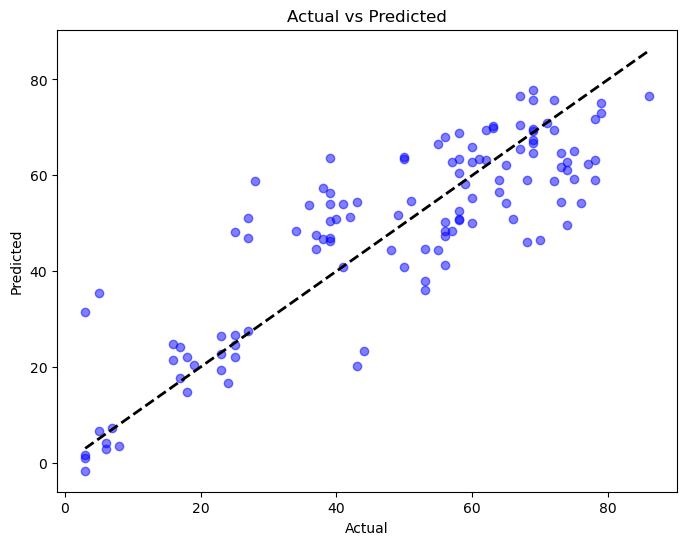

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, results_transformed, color='blue', alpha=0.5)
plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [169]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_transformed, results_transformed)
print("R-squared Score:", r2)

R-squared Score: 0.7192248889623777


In [170]:
bm = BaselineMean()
bm.fit(X_train, y_train)

In [171]:
results = bm.predict(X_test)
print(mean_squared_error(y_test, results))

0.0707553198365789


In [172]:
X_test_transformed = std_scaler.inverse_transform(X_test)
y_test_transformed = mm_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(y_test_transformed)
results_transformed = mm_scaler.inverse_transform(results.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_transformed, results_transformed)
print("Mean Squared Error:", mse)
mae = median_absolute_error(y_test_transformed, results_transformed)
print("Median Absolute Error:", mae)

[ 3. 74. 62. 69. 69. 64. 49. 58. 51. 79. 39. 16. 43.  5. 68.  8. 74. 65.
 18. 58. 34. 53. 59. 27. 86. 36. 79. 66. 48. 57. 50. 58. 17. 56. 72. 55.
 78. 16. 60. 69. 73. 23. 58.  3. 68. 41. 24. 67. 25. 53. 25. 69. 39. 57.
 56. 58. 69. 41.  3. 55. 62. 69. 71. 50. 60.  6. 69. 27. 37. 25. 42.  3.
  5. 38. 17. 78.  6. 28. 77. 23. 39. 72. 56. 37. 39. 65. 60. 19. 75. 25.
 39. 61. 73. 53. 43. 44. 56. 56. 39. 40. 76.  7. 73. 64. 50. 63. 58. 60.
 72. 18. 63. 23. 75. 78. 70. 27. 67. 74. 67. 38.]
Mean Squared Error: 487.43339835419204
Median Absolute Error: 19.921787709497195


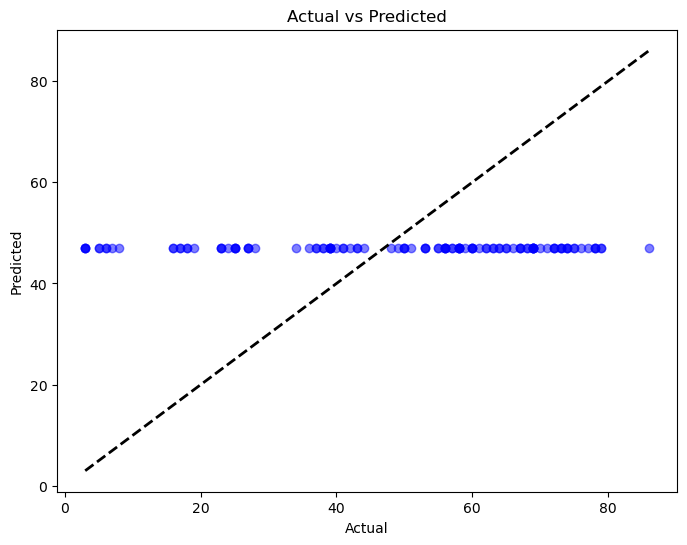

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, results_transformed, color='blue', alpha=0.5)
plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [174]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_transformed, results_transformed)
print("R-squared Score:", r2)

R-squared Score: -0.006482076191692165


In [175]:
br = BaselineRandom(random_state=SEED)
br.fit(X_train, y_train)

In [176]:
results = br.predict(X_test)
print(mean_squared_error(y_test, results))

0.15883329347131367


In [177]:
X_test_transformed = std_scaler.inverse_transform(X_test)
y_test_transformed = mm_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(y_test_transformed)
results_transformed = mm_scaler.inverse_transform(results.reshape(-1, 1)).ravel()
mse = mean_squared_error(y_test_transformed, results_transformed)
print("Mean Squared Error:", mse)
mae = median_absolute_error(y_test_transformed, results_transformed)
print("Median Absolute Error:", mae)

[ 3. 74. 62. 69. 69. 64. 49. 58. 51. 79. 39. 16. 43.  5. 68.  8. 74. 65.
 18. 58. 34. 53. 59. 27. 86. 36. 79. 66. 48. 57. 50. 58. 17. 56. 72. 55.
 78. 16. 60. 69. 73. 23. 58.  3. 68. 41. 24. 67. 25. 53. 25. 69. 39. 57.
 56. 58. 69. 41.  3. 55. 62. 69. 71. 50. 60.  6. 69. 27. 37. 25. 42.  3.
  5. 38. 17. 78.  6. 28. 77. 23. 39. 72. 56. 37. 39. 65. 60. 19. 75. 25.
 39. 61. 73. 53. 43. 44. 56. 56. 39. 40. 76.  7. 73. 64. 50. 63. 58. 60.
 72. 18. 63. 23. 75. 78. 70. 27. 67. 74. 67. 38.]
Mean Squared Error: 1094.20255872388
Median Absolute Error: 24.367676637929193


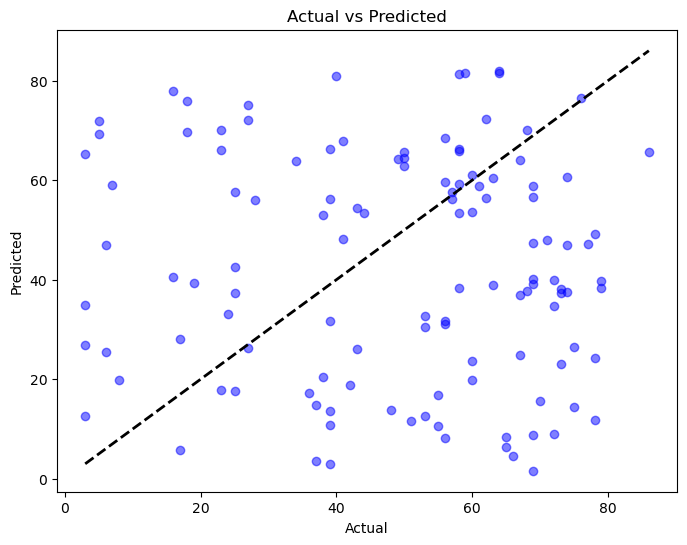

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_transformed, results_transformed, color='blue', alpha=0.5)
plt.plot([y_test_transformed.min(), y_test_transformed.max()], [y_test_transformed.min(), y_test_transformed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [179]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_transformed, results_transformed)
print("R-squared Score:", r2)

R-squared Score: -1.2593758794476777
